In [1]:
from speech_utils import SpeechConverter, sr
from TTS_DataLoader import text_to_seq_char_level, symbols_len
from models.Seq2SeqTTS import Seq2SeqTTS
import torch
from IPython.display import Audio, display
from model_loader import get_model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%load_ext autoreload
%autoreload 2
print(f'Inference running on device={device}')


/home/sid/Desktop/wpi/kdd/Text-2-Audio/kdd4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Inference running on device=cuda


In [2]:
input_raw_text = "transformers are so fast!"
input_indexed = text_to_seq_char_level(input_raw_text) # throw error in text_to_seq for invalid input
input_indexed = input_indexed.unsqueeze(0).to(device)
print(input_indexed)
print(input_indexed.shape)

tensor([[28, 26,  9, 22, 27, 14, 23, 26, 21, 13, 26, 27,  2,  9, 26, 13,  2, 27,
         23,  2, 14,  9, 27, 28,  3,  1]], device='cuda:0', dtype=torch.int32)
torch.Size([1, 26])


In [3]:
TRANSFORMER_MODEL = 'TransformerTTS'
SEQ2SEQ_GRU_MODEL = 'Seq2SeqTTS_GRU'

SPLIT_TRAIN = 'Train'
SPLIT_VAL = 'Validation'

MEL_BINS = 80


In [4]:
model_name = TRANSFORMER_MODEL
split_type = SPLIT_VAL
#TODO remove .bak
model_checkpoint_path = f'./checkpoints/{model_name}/{split_type}.pt'
model = get_model(model_name, MEL_BINS).to(device)
model.load_state_dict(torch.load(model_checkpoint_path, weights_only=True, map_location=device))

<All keys matched successfully>

In [5]:
mel, stop_token = model.inference(input_indexed, device, max_length=400, mel_bins=80, stop_token_threshold = 0.5)
print(mel.shape)

Max inference length reached.
torch.Size([1, 400, 80])


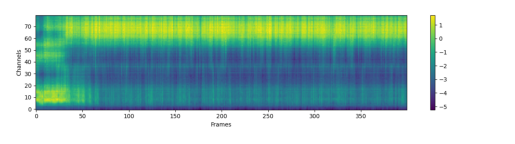

In [6]:
from logging_utils import spectrogram_to_numpy
import matplotlib.pyplot as plt
%matplotlib inline
mel = mel.detach().cpu()
mel_num = spectrogram_to_numpy(mel.data.cpu().numpy().T)
mel_num = mel_num.transpose(1,2,0)
plt.axis('off')
plt.imshow(mel_num)


In [7]:
SC = SpeechConverter(MEL_BINS)
mel = mel.detach().cpu()
audio_waveform = SC.inverse_mel_spec_to_wav(mel.permute(0,2,1))


In [8]:
aud = Audio(data=audio_waveform, rate=sr)
display(aud)